# 语义分割和数据集

图像分类关心识别图像里面的主要目标，目标识别则进一步找出图像的多个目标以及它们的方形边界框。本小节我们将介绍语义分割（semantic segmentation），它在目标识别上更进一步的找出目标的精确边界框。换句话说，它识别图像中的每个像素属于哪类我们感兴趣的目标还是只是背景。图 9.10 演示猫和狗图像在语义分割中的标注。可以看到，跟目标识别相比，语义分割预测的边框更加精细。

![语义分割的训练数据和标注。](../img/segmentation.svg)

在计算机视觉里，还有两个跟语义分割相似的任务。一个是图像分割（image segmentation），它也是将像素划分到不同的类。不同的是，语义分割里我们赋予像素语义信息，例如属于猫、狗或者背景。而图像分割则通常根据像素本身之间的相似性，它训练时不需要像素标注信息，其预测结果也不能保证有语义性。例如图像分割可能将图 9.10 中的狗划分成两个区域，其中一个嘴巴和眼睛，其颜色以黑色为主，另一个是身体其余部分，其主色调是黄色。

另一个应用是实例分割（instance segementation），它不仅需要知道每个像素的语义，即属于哪一类目标，还需要进一步区分目标实例。例如如果图像中有两只狗，那么对于预测为对应狗的像素是属于第一只狗还是第二只。

## Pascal VOC 语义分割数据集

下面我们使用一个常用的语义分割数据集
[Pascal VOC2012](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/)来介绍这个应用。

In [1]:
import sys
sys.path.insert(0, '..')

%matplotlib inline
import gluonbook as gb
from mxnet import gluon, image, nd
from mxnet.gluon import data as gdata, utils as gutils
import os
import sys
import tarfile

我们首先下载这个数据集到`../data`路径下。压缩包大小是 2GB，下载需要一定时间。解压之后这个数据集将会放置在`../data/VOCdevkit/VOC2012`路径下。

In [2]:
# 本函数已保存在 gluonbook 包中方便以后使用。
def download_voc_pascal(data_dir='../data'):
    """Download the Pascal VOC2012 Dataset."""
    voc_dir = os.path.join(data_dir, 'VOCdevkit/VOC2012')
    url = ('http://host.robots.ox.ac.uk/pascal/VOC/voc2012'
           '/VOCtrainval_11-May-2012.tar')
    sha1 = '4e443f8a2eca6b1dac8a6c57641b67dd40621a49'
    fname = gutils.download(url, data_dir, sha1_hash=sha1)
    with tarfile.open(fname, 'r') as f:
        f.extractall(data_dir)
    return voc_dir

voc_dir = download_voc_pascal()

在`ImageSets/Segmentation`下有文本文件指定哪些样本用来训练，哪些用来测试。样本图像放置在`JPEGImages`下，标注则放在`SegmentationClass`下。这里标注也是图像格式，图像大小与对应的样本图像一致，其中颜色相同的像素属于同一个类。

下面定义函数将图像和标注全部读进内存。

In [3]:
# 本函数已保存在 gluonbook 包中方便以后使用。
def read_voc_images(root=voc_dir, is_train=True):
    txt_fname = '%s/ImageSets/Segmentation/%s' % (
        root, 'train.txt' if is_train else 'val.txt')
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    features, labels = [None] * len(images), [None] * len(images)
    for i, fname in enumerate(images):
        features[i] = image.imread('%s/JPEGImages/%s.jpg' % (root, fname))
        labels[i] = image.imread(
            '%s/SegmentationClass/%s.png' % (root, fname))
    return features, labels

train_features, train_labels = read_voc_images()

我们画出前面五张图像和它们对应的标注。在标注，白色代表边框黑色代表背景，其他不同的颜色对应不同目标类别。

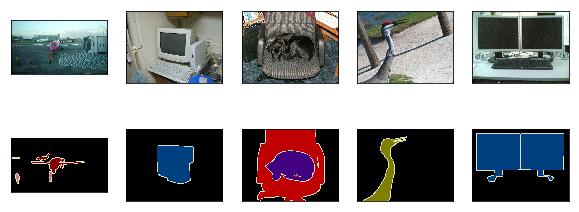

In [4]:
n = 5
imgs = train_features[0:n] + train_labels[0:n]
gb.show_images(imgs, 2, n);

接下来我们列出标注中每个 RGB 颜色值对应的类别。

In [5]:
# 该常量已保存在 gluonbook 包中方便以后使用。
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]
# 该常量已保存在 gluonbook 包中方便以后使用。
VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

这样给定一个标号图像，我们就可以将每个像素对应的目标标号找出来。

In [6]:
colormap2label = nd.zeros(256 ** 3)
for i, colormap in enumerate(VOC_COLORMAP):
    colormap2label[(colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i

# 本函数已保存在 gluonbook 包中方便以后使用。
def voc_label_indices(colormap, colormap2label):
    colormap = colormap.astype('int32')
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256
           + colormap[:, :, 2])
    return colormap2label[idx]

可以看到第一张样本中飞机头部对应的标注里属于飞机的像素被标记成了 1。

In [7]:
y = voc_label_indices(train_labels[0], colormap2label)
y[105:115, 130:140], VOC_CLASSES[1]

(
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
  [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
  [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
  [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
  [0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
  [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
  [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
  [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
  [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]]
 <NDArray 10x10 @cpu(0)>, 'aeroplane')

### 数据预处理

我们知道小批量训练需要输入图像的形状一致。之前我们通过图像缩放来得到同样形状的输入。但语义分割里，如果对样本图像进行缩放，那么重新映射每个像素对应的类别将变得困难，特别是对应目标边缘的像素。

为了避免这个困难，这里我们将图像裁剪成固定大小而不是缩放。特别的，我们使用随机裁剪来附加图像增广。下面定义随机裁剪函数，其对样本图像和标注使用同样的裁剪。

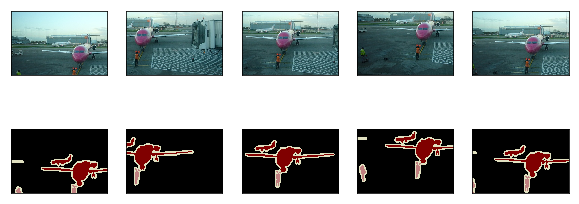

In [8]:
# 本函数已保存在 gluonbook 包中方便以后使用。
def voc_rand_crop(feature, label, height, width):
    feature, rect = image.random_crop(feature, (width, height))
    label = image.fixed_crop(label, *rect)
    return feature, label

imgs = []
for _ in range(n):
    imgs += voc_rand_crop(train_features[0], train_labels[0], 200, 300)
gb.show_images(imgs[::2] + imgs[1::2], 2, n);

### 数据读取

下面我们定义 Gluon 可以使用的数据集类，它可以返回任意的第 $i$ 个样本图像和标号。除了随机裁剪外，这里我们将样本图像进行了归一化，同时过滤了小裁剪尺寸的图像。

In [9]:
# 本类已保存在 gluonbook 包中方便以后使用。
class VOCSegDataset(gdata.Dataset):
    def __init__(self, is_train, crop_size, voc_dir, colormap2label):
        self.rgb_mean = nd.array([0.485, 0.456, 0.406])
        self.rgb_std = nd.array([0.229, 0.224, 0.225])
        self.crop_size = crop_size        
        features, labels = read_voc_images(root=voc_dir, is_train=is_train)
        self.features = [self.normalize_image(feature)
                         for feature in self.filter(features)]
        self.labels = self.filter(labels)
        self.colormap2label = colormap2label
        print('read ' + str(len(self.features)) + ' examples')
        
    def normalize_image(self, img):
        return (img.astype('float32') / 255 - self.rgb_mean) / self.rgb_std
    
    def filter(self, imgs):
        return [img for img in imgs if (
            img.shape[0] >= self.crop_size[0] and
            img.shape[1] >= self.crop_size[1])]

    def __getitem__(self, idx):
        feature, label = voc_rand_crop(self.features[idx], self.labels[idx],
                                       *self.crop_size)
        return (feature.transpose((2, 0, 1)),
                voc_label_indices(label, self.colormap2label))

    def __len__(self):
        return len(self.features)

假设我们裁剪 $320\times 480$ 图像来进行训练，我们可以查看训练和测试各保留了多少图像。

In [10]:
output_shape = (320, 480)  # 高和宽。
voc_train = VOCSegDataset(True, output_shape, voc_dir, colormap2label)
voc_test = VOCSegDataset(False, output_shape, voc_dir, colormap2label)

read 1114 examples


read 1078 examples


最后定义批量读取，这里使用 4 个进程来加速读取（暂不支持 Windows 操作系统）。

In [11]:
batch_size = 64
num_workers = 0 if sys.platform.startswith('win32') else 4
train_iter = gdata.DataLoader(voc_train, batch_size, shuffle=True,
                              last_batch='discard', num_workers=num_workers)
test_iter = gdata.DataLoader(voc_test, batch_size, last_batch='discard',
                             num_workers=num_workers)

打印第一个批量可以看到，不同于图像分类和目标识别，这里的标签是一个三维的数组。

In [12]:
for X, Y in train_iter:
    print(X.shape)
    print(Y.shape)
    break

(64, 3, 320, 480)
(64, 320, 480)


## 小结

* 语义分割识别图像中每个像素的类别。
* 语义分割数据集中的标注由于跟跟样本图像有像素级的对应，使得其对应用图像变形类增广时有一定的限制。

## 练习

* 对比下有哪些图像分类上使用的图像增广比较难在语义分割上使用。

## 扫码直达[讨论区](https://discuss.gluon.ai/t/topic/7218)

![](../img/qr_semantic-segmentation-and-dataset.svg)